# Config

In [11]:
import os
import json
import time
import torch
import pprint
import random
import pandas
import argparse
import lightning

import numpy as np
import mdtraj as md
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from torch.utils.data import Dataset



In [12]:
class CL_dataset(Dataset):
	def __init__(
		self,
		data_list,
		data_augmented_list,
		data_augmented_hard_list,
		temperature_list,
		energy_list
	):
		super(CL_dataset, self).__init__()
		self.device = "cpu"
		
		self.x = data_list.to(self.device)
		self.x_augmented = data_augmented_list.to(self.device)
		self.x_augmented_hard = data_augmented_hard_list.to(self.device)
		self.temperature = temperature_list.to(self.device)
		self.energy = energy_list.to(self.device)
		
	def __getitem__(self, index):
		return self.x[index], self.x_augmented[index], self.x_augmented_hard[index], self.temperature[index], self.energy[index]

	def __len__(self):
		return self.x.shape[0]

In [14]:
molecule = "alanine"
temperature = "300.0"
version = "10n-v1"

ALDP_PHI_ANGLE = [4, 6, 8, 14]
ALDP_PSI_ANGLE = [6, 8, 14, 16]

# Projection Dataset

In [4]:
dataset_xyz = torch.load(f"../dataset/{molecule}/{temperature}/{version}/cl-xyz.pt")
dataset_distance = torch.load(f"../dataset/{molecule}/{temperature}/{version}/cl-distance.pt")

In [6]:
state_phi = np.load(f"../dataset/{molecule}/{temperature}/{version}/state_phi.npy")
state_psi = np.load(f"../dataset/{molecule}/{temperature}/{version}/state_psi.npy")
positive_phi = np.load(f"../dataset/{molecule}/{temperature}/{version}/positive_phi.npy")
positive_psi = np.load(f"../dataset/{molecule}/{temperature}/{version}/positive_psi.npy")
negative_phi = np.load(f"../dataset/{molecule}/{temperature}/{version}/negative_phi.npy")
negative_psi = np.load(f"../dataset/{molecule}/{temperature}/{version}/negative_psi.npy")

## Visualization

<Figure size 640x480 with 0 Axes>

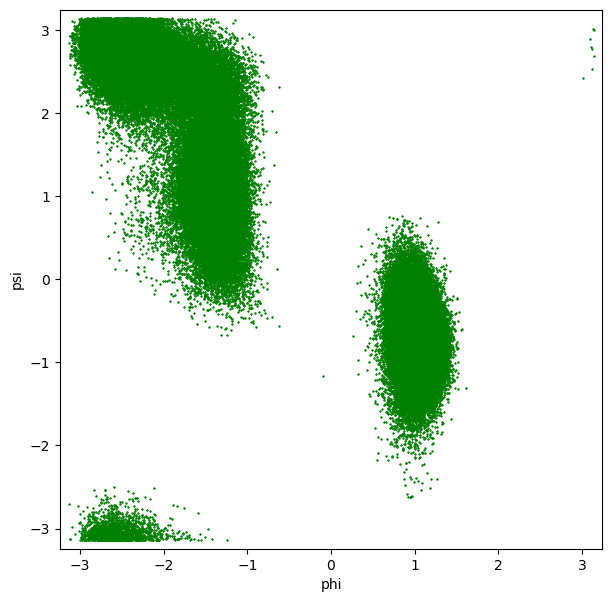

In [12]:
plt.clf()
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

ax.plot(
	state_phi,
	state_psi,
	marker="o",
	linestyle="None",
	markersize=0.5,
	alpha=1.0,
	zorder=100,
 	color="green",
)
# ax.plot(
# 	positive_phi,
# 	positive_psi,
# 	marker="o",
# 	linestyle="None",
# 	markersize=0.5,
# 	alpha=1.0,
# 	zorder=100,
#  	color="green",
# )
# ax.plot(
# 	negative_phi,
# 	negative_psi,
# 	marker="o",
# 	linestyle="None",
# 	markersize=0.5,
# 	alpha=1.0,
# 	zorder=100,
#  	color="green",
# )

# Plot the Ramachandran plot
plt.xlim([-np.pi - 0.1, np.pi + 0.1])
plt.ylim([-np.pi - 0.1, np.pi + 0.1])
plt.xlabel("phi")
plt.ylabel("psi")
plt.show()

# Create projection dataset

In [37]:
projection_num = state_phi.shape[0]
print(projection_num)
print(dataset_xyz[:projection_num][0].shape, dataset_distance[:projection_num][0].shape)


400000
torch.Size([400000, 22, 3]) torch.Size([400000, 45])


In [39]:
save_dir = f"../projection/{molecule}/simulation"
if not os.path.exists(save_dir):
	os.makedirs(save_dir)

In [40]:
# if not os.path.exists(f"{save_dir}/coordinate.pt"):
# 	torch.save(dataset_xyz[:projection_num][0], f"{save_dir}/coordinate.pt")
# if not os.path.exists(f"{save_dir}/heavy_atom_distance.pt"):
# 	torch.save(dataset_distance[:projection_num][0], f"{save_dir}/heavy_atom_distance.pt")
if not os.path.exists(f"{save_dir}/phi.npy"):
	np.save(f"{save_dir}/phi.npy", state_phi)
if not os.path.exists(f"{save_dir}/psi.npy"):
	np.save(f"{save_dir}/psi.npy", state_psi)

# Dihedral

In [5]:
def compute_dihedral_torch(
    positions: torch.Tensor,
) -> torch.Tensor:
    """
        Computes the dihedral angle for batches of points P1, P2, P3, P4.
        Args:
            positions: (bacth_size, 4, 3)
        Returns:
            A tensor of shape (batch_size,) containing the dihedral angles in radians.
    """

    P1 = positions[:, 0]
    P2 = positions[:, 1]
    P3 = positions[:, 2]
    P4 = positions[:, 3]
    b1 = P2 - P1
    b2 = P3 - P2
    b3 = P4 - P3
    
    b2_norm = b2 / b2.norm(dim=1, keepdim=True)
    n1 = torch.cross(b1, b2, dim=1)
    n2 = torch.cross(b2, b3, dim=1)
    n1_norm = n1 / n1.norm(dim=1, keepdim=True)
    n2_norm = n2 / n2.norm(dim=1, keepdim=True)
    m1 = torch.cross(n1_norm, b2_norm, dim=1)
    
    # Compute cosine and sine of the angle
    x = (n1_norm * n2_norm).sum(dim=1)
    y = (m1 * n2_norm).sum(dim=1)
    angle = - torch.atan2(y, x)
    
    return angle

In [20]:
save_dir = f"../dataset/{molecule}/{temperature}/{version}"

In [21]:
state_phi = compute_dihedral_torch(dataset_xyz.x[:, ALDP_PHI_ANGLE])
state_psi = compute_dihedral_torch(dataset_xyz.x[:, ALDP_PSI_ANGLE])
print(state_phi.shape, state_psi.shape)
np.save(f"{save_dir}/state_phi.npy", state_phi)
np.save(f"{save_dir}/state_psi.npy", state_psi)


torch.Size([400000]) torch.Size([400000])


In [22]:
positive_phi = compute_dihedral_torch(dataset_xyz.x_augmented[:, ALDP_PHI_ANGLE])
positive_psi = compute_dihedral_torch(dataset_xyz.x_augmented[:, ALDP_PSI_ANGLE])
np.save(f"{save_dir}/positive_phi.npy", positive_phi)
np.save(f"{save_dir}/positive_psi.npy", positive_psi)

negative_phi = compute_dihedral_torch(dataset_xyz.x_augmented_hard[:, ALDP_PHI_ANGLE])
negative_psi = compute_dihedral_torch(dataset_xyz.x_augmented_hard[:, ALDP_PSI_ANGLE])
np.save(f"{save_dir}/negative_phi.npy", negative_phi)
np.save(f"{save_dir}/negative_psi.npy", negative_psi)